# GAN テスト

In [1]:
import tensorflow as tf

In [2]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
#train_images = train_images[np.where((train_labels==8) | (train_labels==9))]
#train_labels = train_labels[np.where(train_labels==8 | (train_labels==9))]

In [5]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = train_images / 256.0   # Normalize the images to [0, 1]

In [6]:
BUFFER_SIZE = len(train_labels)
BATCH_SIZE = 255

In [7]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [8]:
class ComplexDense(tf.keras.layers.Layer):

  def __init__(self, units=32):
      super(ComplexDense, self).__init__()
      self.units = units

  def build(self, input_shape):
      self.w_real = self.add_weight(shape=(input_shape[-1], self.units),
                               initializer='random_normal',
                               trainable=True)
      self.w_imag = self.add_weight(shape=(input_shape[-1], self.units),
                               initializer='random_normal',
                               trainable=True)

      #self.b_real = self.add_weight(shape=(self.units,), initializer='random_normal', trainable=True)
      #self.b_imag = self.add_weight(shape=(self.units,), initializer='random_normal', trainable=True)

  def call(self, inputs):
      return tf.matmul(inputs, tf.complex(self.w_real, self.w_imag))# + tf.complex(self.b_real, self.b_imag)

In [9]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [10]:
def make_complex_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Lambda(lambda x: tf.complex(tf.cos(x), tf.sin(x))))
    model.add(ComplexDense(200*200))
    model.add(layers.Lambda(lambda x:tf.abs(x)**2))
    model.add(layers.Reshape((200, 200)))
    model.add(layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)))
    return model

In [11]:
generator = make_generator_model()
generator.input_shape

(None, 100)

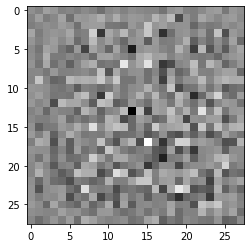

In [12]:
generator = make_generator_model()

noise = tf.random.normal([1, 100], dtype=tf.float32)
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [18]:
generator = make_complex_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :,0], cmap='gray')

2022-11-07 01:54:04.943637: E tensorflow/stream_executor/cuda/cuda_blas.cc:232] failed to create cublas handle: CUBLAS_STATUS_NOT_INITIALIZED
2022-11-07 01:54:04.943712: E tensorflow/stream_executor/cuda/cuda_blas.cc:234] Failure to initialize cublas may be due to OOM (cublas needs some free memory when you initialize it, and your deep-learning framework may have preallocated more than its fair share), or may be because this binary was not built with support for the GPU in your machine.
2022-11-07 01:54:04.943748: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at matmul_op_impl.h:438 : INTERNAL: Attempting to perform BLAS operation using StreamExecutor without BLAS support


InternalError: Exception encountered when calling layer "complex_dense_1" (type ComplexDense).

Attempting to perform BLAS operation using StreamExecutor without BLAS support [Op:MatMul]

Call arguments received by layer "complex_dense_1" (type ComplexDense):
  • inputs=tf.Tensor(shape=(1, 100), dtype=complex64)

In [13]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Lambda(lambda x: tf.image.resize(x, (28, 28))))
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [14]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00107243]], shape=(1, 1), dtype=float32)


In [15]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [16]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [17]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [18]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [19]:
model_name = "20221024_1"
checkpoint_dir = "checkpoint/" + model_name
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [20]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [34]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    #noise = tf.random.normal([BATCH_SIZE, noise_dim])
    noise = tf.random.uniform([BATCH_SIZE, noise_dim], -np.pi, np.pi)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [35]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    #if (epoch + 1) % 15 == 0:
      #checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [36]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

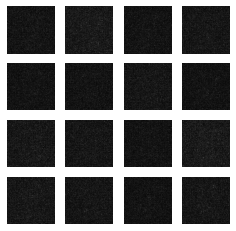

Time for epoch 19 is 7.155193567276001 sec


In [ ]:
train(train_dataset, EPOCHS)

# MO-GAN

In [25]:
# paperspace gradient用
! rm -rf MOD2NN
! git clone https://$$TOKEN@github.com/konnitiha3/MOD2NN.git

import sys
sys.path.append('/notebooks/MOD2NN')

Cloning into 'MOD2NN'...
remote: Enumerating objects: 1489, done.
remote: Counting objects: 100% (254/254), done.
remote: Compressing objects: 100% (148/148), done.
remote: Total 1489 (delta 140), reused 175 (delta 85), pack-reused 1235s:   4% (60/1489), 4.32 MiB | 2.09 MiB/sReceiving objects:   6% (90/1489), 4.32 MiB | 2.09 MiB/sReceiving objects:   7% (113/1489), 5.16 MiB | 1.96 MiB/sReceiving objects:   9% (135/1489), 6.08 MiB | 1.92 MiB/sReceiving objects:  11% (164/1489), 7.05 MiB | 1.93 MiB/sReceiving objects:  12% (188/1489), 8.00 MiB | 1.59 MiB/sReceiving objects:  14% (209/1489), 8.00 MiB | 1.59 MiB/sReceiving objects:  18% (269/1489), 8.00 MiB | 1.59 MiB/sReceiving objects:  20% (298/1489), 8.59 MiB | 1.54 MiB/sReceiving objects:  23% (356/1489), 9.46 MiB | 1.56 MiB/sReceiving objects:  25% (373/1489), 9.46 MiB | 1.56 MiB/sReceiving objects:  27% (403/1489), 10.55 MiB | 1.54 MiB/sReceiving objects:  28% (417/1489), 11.67 MiB | 1.50 MiB/sReceiving objects:  30% (447/1489), 11.

In [354]:
import sys
sys.path.append('/notebooks/MOD2NN')

In [355]:
import time
import sys

from Faraday.two_dim.module.lib.layers import *

tf.random.set_seed(1)

print("TensorFlow:", tf.__version__)
print("Python:", sys.version)

plt.rcParams['font.size'] = 18

TensorFlow: 2.9.1
Python: 3.9.13 (main, May 23 2022, 22:01:06) 
[GCC 9.4.0]


In [607]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images[np.where((train_labels != 1))]
train_labels = train_labels[np.where((train_labels != 1))]

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = train_images / 256.0  # Normalize the images to [0, 1]

BUFFER_SIZE = len(train_labels)
BATCH_SIZE = 256
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [608]:
class RandomPolarization(tf.keras.layers.Layer):
    def __init__(self, input_dist=None, trainable=False, name=None, dtype=tf.float32, **kwargs):
        self.input_dist = None # input light distribution. if it is None, uniform distribution
        super(RandomPolarization, self).__init__(
            trainable=trainable,
            name=name,
            dtype=dtype,
            **kwargs
        )

    def build(self, input_dim):
        E0 = tf.constant(self.input_dist) if self.input_dist is not None else tf.ones((input_dim[-2], input_dim[-1]))
        self.rcp_x = tf.complex(tf.sqrt(E0 / 2.0), 0.0 * E0)
        self.lcp_x = tf.complex(tf.sqrt(E0 / 2.0), 0.0 * E0)
        super(RandomPolarization, self).build(input_dim)

    @classmethod
    def from_config(cls, config):
        return cls(**config)

    def call(self, x):
        phi = tf.complex(x, 0.0*x)

        rcp_x_mo = self.rcp_x * tf.exp(-1.j * phi)
        lcp_x_mo = self.lcp_x * tf.exp(1.j* phi)
        return tf.stack([rcp_x_mo, lcp_x_mo], axis=1)

In [609]:
inputs = tf.keras.Input((28,28))
x = RandomPolarization()(inputs)
x = MO((28, 28))(x)
model = tf.keras.Model(inputs, x)

In [610]:
wavelength = 633e-9
d = 1.0e-6
n = 1.0

In [611]:
def make_generator_model(out_shape):
    model = tf.keras.Sequential()
    model.add(ImageResizing(out_shape))
    model.add(RandomPolarization())
    model.add(AngularSpectrum(out_shape, wavelength=wavelength, z=0.3e-3, d=d, n=1.0, normalization="max"))
    model.add(MO(out_shape, limitation="sin", theta=np.pi, eta=0.))
    model.add(AngularSpectrum(out_shape, wavelength=wavelength, z=0.3e-3, d=d, n=1.0, normalization="max"))
    model.add(MO(out_shape, limitation="sin", theta=np.pi, eta=0.))
    model.add(AngularSpectrum(out_shape, wavelength=wavelength, z=0.3e-3, d=d, n=1.0, normalization="max"))
    model.add(MO(out_shape, limitation="sin", theta=np.pi, eta=0.))
    model.add(AngularSpectrum(out_shape, wavelength=wavelength, z=0.3e-3, d=d, n=1.0, normalization="max"))
    model.add(MO(out_shape, limitation="sin", theta=np.pi, eta=0.))
    model.add(AngularSpectrum(out_shape, wavelength=wavelength, z=0.3e-3, d=d, n=1.0, normalization="max"))
    model.add(MO(out_shape, limitation="sin", theta=np.pi, eta=0.))
    model.add(AngularSpectrum(out_shape, wavelength=wavelength, z=0.3e-3, d=d, n=1.0, normalization="max"))
    model.add(MO(out_shape, limitation="sin", theta=np.pi, eta=0.))
    model.add(AngularSpectrum(out_shape, wavelength=wavelength, z=0.3e-3, d=d, n=1.0, normalization="max"))
    model.add(MO(out_shape, limitation="sin", theta=np.pi, eta=0.))
    model.add(AngularSpectrum(out_shape, wavelength=wavelength, z=0.3e-3, d=d, n=1.0, normalization="max"))
    model.add(MO(out_shape, limitation="sin", theta=np.pi, eta=0.))
    model.add(AngularSpectrum(out_shape, wavelength=wavelength, z=0.3e-3, d=d, n=1.0, normalization="max"))
    model.add(MO(out_shape, limitation="sin", theta=np.pi, eta=0.))
    model.add(AngularSpectrum(out_shape, wavelength=wavelength, z=0.3e-3, d=d, n=1.0, normalization="max"))
    model.add(MO(out_shape, limitation="sin", theta=np.pi, eta=0.))
    model.add(AngularSpectrum(out_shape, wavelength=wavelength, z=0.3e-3, d=d, n=1.0, normalization="max"))
    model.add(MO(out_shape, limitation="sin", theta=np.pi, eta=0.))
    model.add(AngularSpectrum(out_shape, wavelength=wavelength, z=0.3e-3, d=d, n=1.0, normalization="max"))
    model.add(Polarizer(out_shape, trainable=True))
    model.add(ElectricFieldToIntensity(out_shape))
    model.add(tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)))
    return model

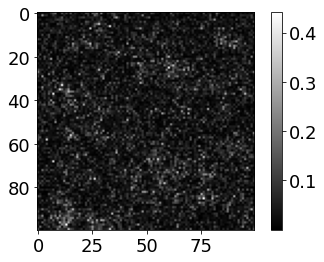

In [612]:
generator = make_generator_model((100, 100))

noise = tf.random.uniform([1, 10, 10], -np.pi, np.pi)
generated_image = generator(noise)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()

In [613]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Lambda(lambda x: tf.image.resize(x, (28, 28))))
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [614]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00427211]], shape=(1, 1), dtype=float32)


In [615]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

model_name = "20221024_2"
checkpoint_dir = "checkpoint/" + model_name
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [616]:
EPOCHS = 50
noise_dim = [10, 10]
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, *noise_dim])

In [617]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.uniform([BATCH_SIZE, *noise_dim], -np.pi/2, np.pi/2)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [618]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # evaluate loss
    fake_output = generator(seed, training=False)
    gen_loss = generator_loss(fake_output)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start), f'{gen_loss=}')

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [619]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('images/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

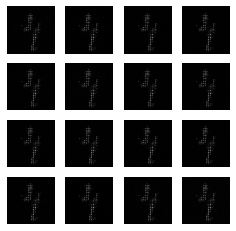

In [620]:
train(train_dataset, EPOCHS)

# ComplexNNテスト

In [20]:
import sys
sys.path.append('/notebooks/MOD2NN')

In [22]:
from Faraday.two_dim.module.lib.layers import *

In [4]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# Reserve 10,000 samples for validation
x_val = x_train[-5000:]
y_val = y_train[-5000:]
x_train = x_train[:-5000]
y_train = y_train[:-5000]

11490434/11490434 [==============================] - 0s 0us/step


In [50]:
class ComplexDense(tf.keras.layers.Layer):

  def __init__(self, units=32):
      super(ComplexDense, self).__init__()
      self.units = units

  def build(self, input_shape):
      self.w_real = self.add_weight(shape=(input_shape[-1], self.units),
                               initializer='random_normal',
                               trainable=True)
      self.w_imag = self.add_weight(shape=(input_shape[-1], self.units),
                               initializer='random_normal',
                               trainable=True)

      #self.b_real = self.add_weight(shape=(self.units,), initializer='random_normal', trainable=True)
      #self.b_imag = self.add_weight(shape=(self.units,), initializer='random_normal', trainable=True)

  def call(self, inputs):
      return tf.matmul(inputs, tf.complex(self.w_real, self.w_imag))# + tf.complex(self.b_real, self.b_imag)

In [6]:
class SimpleDense(tf.keras.layers.Layer):

  def __init__(self, units=32):
      super(SimpleDense, self).__init__()
      self.units = units

  def build(self, input_shape):
      self.w = self.add_weight(shape=(input_shape[-1], self.units),
                               initializer='random_normal',
                               trainable=True)
      self.b = self.add_weight(shape=(self.units,),
                               initializer='random_normal',
                               trainable=True)

  def call(self, inputs):
      return tf.matmul(inputs, self.w) + self.b

In [17]:
50**2 * 10

25000

In [51]:
model = tf.keras.Sequential()
#model.add(ImageResizing((28, 50)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Lambda(lambda x: tf.complex(x, 0.*x)))
model.add(ComplexDense(units=10))
#model.add(SimpleDense(10))
model.add(tf.keras.layers.Lambda(lambda x: tf.abs(x)**2))
#model.add(tf.keras.layers.Lambda(lambda x: tf.sigmoid(x)))

In [52]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # category: sparse_categorical_crossentropy
              metrics=["accuracy"]
              )

In [53]:
def lr_schedule(epoch):
      """
      Returns a custom learning rate that decreases as epochs progress.
      """
      start = 0.1
      end = 0.00001
      n = 30
      a = -1/(n-1) * np.log(end/start)
      return np.exp(-a*(epoch)) * start

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

In [54]:
model.fit(x_train, y_train, epochs=30, callbacks=[lr_callback])

Epoch 1/30
1719/1719 [==============================] - 3s 1ms/step - loss: 158.3474 - accuracy: 0.8240 - lr: 0.1000
Epoch 2/30
1719/1719 [==============================] - 3s 1ms/step - loss: 101.9792 - accuracy: 0.8798 - lr: 0.0728
Epoch 3/30
1719/1719 [==============================] - 3s 2ms/step - loss: 59.0959 - accuracy: 0.8920 - lr: 0.0530
Epoch 4/30
1719/1719 [==============================] - 3s 1ms/step - loss: 34.8145 - accuracy: 0.9035 - lr: 0.0386
Epoch 5/30
1719/1719 [==============================] - 3s 1ms/step - loss: 22.7851 - accuracy: 0.9096 - lr: 0.0281
Epoch 6/30
1719/1719 [==============================] - 3s 1ms/step - loss: 14.3294 - accuracy: 0.9196 - lr: 0.0204
Epoch 7/30
1719/1719 [==============================] - 3s 1ms/step - loss: 9.6582 - accuracy: 0.9253 - lr: 0.0149
Epoch 8/30
1719/1719 [==============================] - 3s 1ms/step - loss: 6.5304 - accuracy: 0.9326 - lr: 0.0108
Epoch 9/30
1719/1719 [==============================] - 3s 1ms/step - lo

In [55]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 6.4288 - accuracy: 0.9168


[6.428838729858398, 0.9168000221252441]

In [61]:
weight = model.get_weights()
weight

[array([[ 0.04568601,  0.03427659,  0.03381527, ...,  0.00731467,
          0.08431601,  0.02293192],
        [ 0.11410806,  0.01412422,  0.09056266, ...,  0.03858967,
         -0.06895169,  0.04204023],
        [-0.10380021,  0.00204712, -0.04724472, ..., -0.06379018,
         -0.01843596, -0.12895113],
        ...,
        [ 0.01317674, -0.01081405,  0.02922334, ..., -0.02723098,
          0.04176488,  0.0316489 ],
        [ 0.02658234,  0.03337771, -0.05996325, ...,  0.03713467,
         -0.08201798,  0.01755194],
        [-0.02405796, -0.08599885, -0.02721875, ...,  0.02780491,
          0.01435385, -0.0384368 ]], dtype=float32),
 array([[ 0.03699511, -0.01557664, -0.02356968, ..., -0.04544824,
         -0.03963709,  0.00880465],
        [-0.04862733, -0.0321048 ,  0.03814552, ...,  0.04857035,
         -0.05459888,  0.0028072 ],
        [ 0.04008314,  0.04534229,  0.05137369, ..., -0.00734491,
         -0.03729443,  0.10663991],
        ...,
        [ 0.04459393, -0.06723332, -0.0

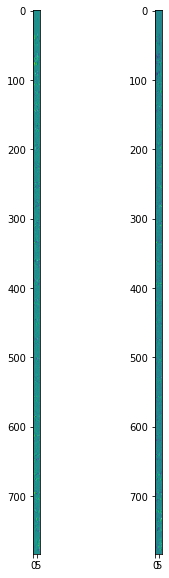

In [64]:
fig = plt.figure(figsize=(4,10))

plt.subplot(1,2,1)
plt.imshow(weight[0])

plt.subplot(1,2,2)
plt.imshow(weight[1])

In [508]:
import numpy as np
import matplotlib.pyplot as plt

#線形補間と連続性を生み出す子たち
def fade(t):return 6*t**5-15*t**4+10*t**3
def lerp(a,b,t):return a+fade(t)*(b-a)

def perlin(r,seed=np.random.randint(0,100)):
    np.random.seed(seed)

    ri = np.floor(r).astype(int) #整数部、インデックスとして使用
    ri[0] -= ri[0].min()         #
    ri[1] -= ri[1].min()         #インデックスとして使用するための準備
    rf = np.array(r) % 1         #小数部
    g = 2 * np.random.rand(ri[0].max()+2,ri[1].max()+2,2) - 1 #格子点の勾配
    e = np.array([[[[0,0],[0,1],[1,0],[1,1]]]])                       #四隅
    er = (np.array([rf]).transpose(2,3,0,1) - e).reshape(r.shape[1],r.shape[2],4,1,2) #四隅の各点から見た位置ベクトル
    gr = np.r_["3,4,0",g[ri[0],ri[1]],g[ri[0],ri[1]+1],g[ri[0]+1,ri[1]],g[ri[0]+1,ri[1]+1]].transpose(0,1,3,2).reshape(r.shape[1],r.shape[2],4,2,1) #おなじみファンシーソートで四隅の勾配をまとめて内積計算できる形に加工
    p = (er@gr).reshape(r.shape[1],r.shape[2],4).transpose(2,0,1) #全点まとめて勾配との内積計算

    return lerp(lerp(p[0],p[2],rf[0]),lerp(p[1],p[3],rf[0]),rf[1]) #補間して返す

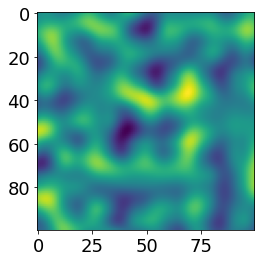

In [510]:
N = 100
y = np.zeros((N,N))
for i in np.random.rand(1):         #パーリンノイズは周波数を変えて何枚か重ねると本領を発揮するらしいのでループして加算（好きなだけどうぞ）
    x = np.linspace(0,8*i,N)
    r = np.array(np.meshgrid(x,x))
    y += perlin(r)                  #meshgridの形(2,N,N)で渡す

plt.imshow(y)
plt.show()